In [1]:
#code concists of cells. To run cell, press play button above or Shift+Enter (on Windows)

#This cell is just importing some libraries
import numpy as np
from matplotlib import pylab, mlab, pyplot

from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *

style.use('ggplot')
rcParams['figure.figsize'] = (25,13)
from numba import jit

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


Classification: Fixed point
Low Voltage


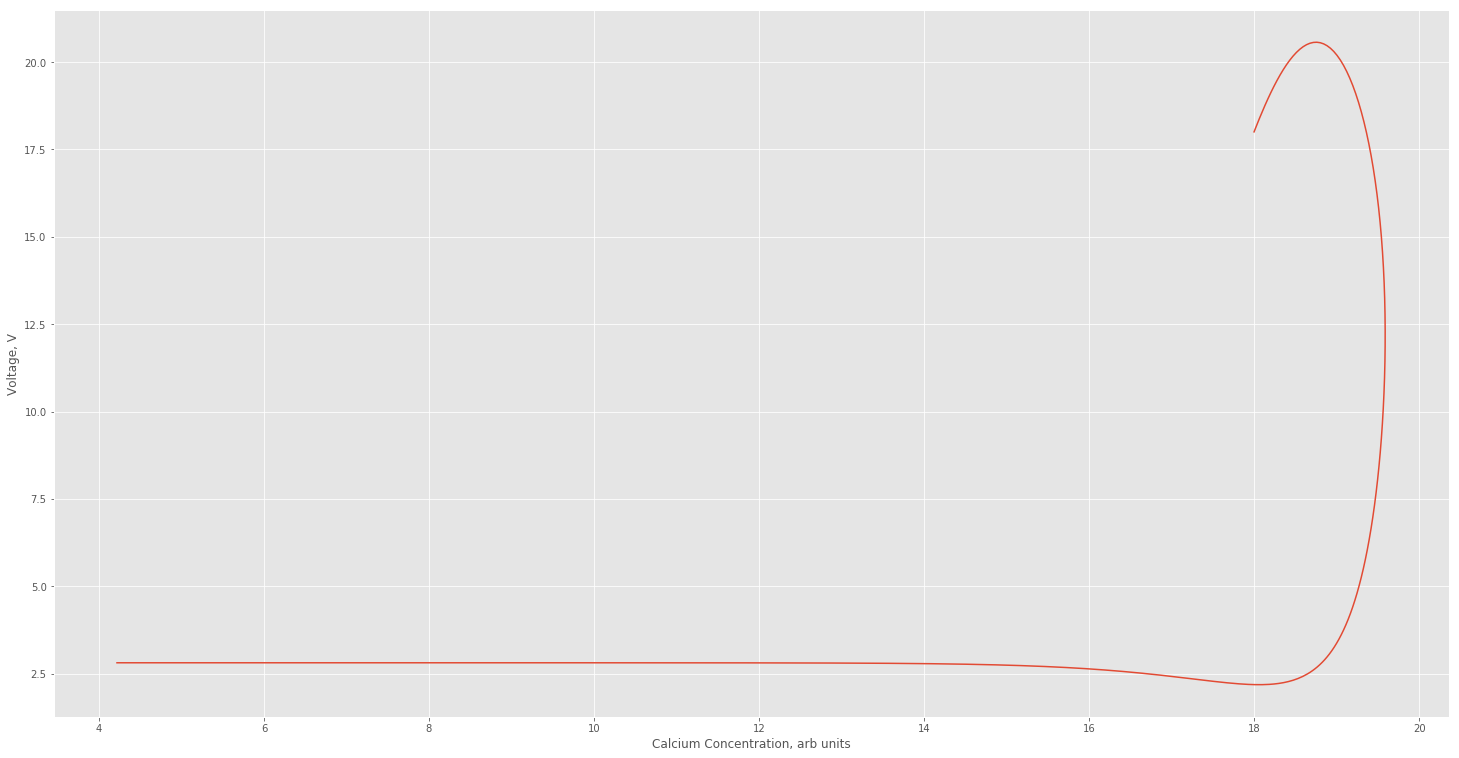

In [14]:
N = 100000 #number of iterations 
dt = .001 #step size 

T = zeros(N) #Time array 
V = zeros(N) #Voltage array 
C = zeros(N) #Calcium concentration array 

#initial potential and calcium concentration
V[0]=18 #orig 18
C[0]=18 #orig 18
#time constants in milliseconds
tauv=0.01 #orig. 0.01
tauc=0.5 #orig. 0.5

#threshold values for potential and calcium concentration
Vstar=15 #orig 15
Cstar=20 #orig 20

#number of neurons
n=100 #orig 100


delV=.5 #constant defining how strong neurons firing affect potential 1.2
delC=.015 #constant defining how strong neurons firing affect calcium concentration .015
r=70  #rate of firing in Hz. Does not present in the equation in the paper because can be hidden in the redefinition of delV and delC orig 70

for i in range(N-1):  #numerical solution of the differential equation. This numerical method, called Newton's, is the most trivial and known for not working 
    #in some cases. We will start with it and later can compare with other, more sophisticated methods. You can google and try it yourself. 
    V[i+1]=(-V[i]/tauv + n*delV*r*(1/(1+exp((Vstar-V[i])*0.2)))*(1/(1+exp(C[i]-Cstar))) )*dt + V[i]  #step function is defined as sigmoid 1/(1+exp)
    C[i+1]=(-C[i]/tauc + delC*n*r*(1/(1+exp((Vstar-V[i])*0.2))))*dt + C[i]
    
# Classification
Vcalc = zeros(N/2) 

for i in range (N/2,N):
    Vcalc[i-N/2]=V[i]
V_delta = max(Vcalc) - min(Vcalc)

#print V_delta #Print the difference between max and min. 
#print V[N-1] #Print the last data point recorded

if V_delta < 1: 
    print ("Classification: Fixed point")
    if V[N-1] < V[0]:
        print ("Low Voltage")
    else: print("High Voltage")
else: print("Classification: Limiting cycle")
    
#Plotting
xlabel("Calcium Concentration, arb units")
ylabel("Voltage, V")
plot(C,V) #we plot phase diagram concentration vs potential. 
show()





In [3]:
# Classification
Vcalc = zeros(N/2) 

for i in range (N/2,N):
    Vcalc[i-N/2]=V[i]
V_delta = max(Vcalc) - min(Vcalc)

print V_delta #Print the difference between max and min. 
print V[N-1] #Print the last data point recorded

if V_delta < 1: 
    print ("Classification: Fixed point")
    if V[N-1] < V[0]:
        print ("Low Voltage")
    else: print("High Voltage")
else: print("Classification: Limiting cycle")


0.0
2.81252281937
Classification: Fixed point
Low Voltage


In [2]:
#embedding as done on master file 
def simdyn(params):
    return simDynamics(params)

@jit(nopython=True)
def simDynamics(params):
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    #res = int(params[12]) #resulting classification 
    
    for i in range(n):
        V[0,i]=V0 #initial conditions
        C[0,i]=C0 
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1): #iterates over time domain 
        for j in range(n): #iterates over space domain 
            V[i+1, j]=(-V[i,j]/tauv + n*delV*r*(1/(1+exp((Vstar-V[i,j])*0.2)))*(1/(1+exp(C[i,j]-Cstar))) )*dt + V[i,j]
            C[i+1]=(-C[i,j]/tauc + delC*n*r*(1/(1+exp((Vstar-V[i,j])*0.2))))*dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
        
        #plot([avC[i],avC[i+1]],[avV[i],avV[i+1]])    
    return(avC,avV)

###Heaviside Step function in place of sigmoid###

#embedding as done on master file 
def simdyn2(params):
    return simDynamics2(params)

@jit(nopython=True)
def simDynamics2(params):
    N=int(params[0])
    n=int(params[1])
    dt=params[2]
    tauv=params[3]
    tauc=params[4]
    Vstar=params[5]
    Cstar=params[6]
    delV=params[7]
    delC=params[8]
    r=params[9]
    V0=params[10]
    C0=params[11]
    V=zeros(N*n).reshape(N,n)  #now we have potencial and calcium concentration for each neuron
    C=zeros(N*n).reshape(N,n)
    P=zeros(n)  # function P(V), sigmoid
    sump=zeros(n)  #sum of P over the vertices
    avV=zeros(N) #average potencial
    avC=zeros(N)  #average calcium
    #res = int(params[12]) #resulting classification 
    
    for i in range(n):
        V[0,i]=V0 #initial conditions
        C[0,i]=C0 
        avV[0]=n*V0  #we will divide to n later
        avC[0]=n*C0
    for i in range (N-1): #iterates over time domain 
        for j in range(n): #iterates over space domain 
            if V[i,j] < Vstar:
                r = 5
            else: 
                r = 70
            if C[i,j] < Cstar: 
                delV = params[7]
            else: 
                delV = 0
            V[i+1, j]=(-V[i,j]/tauv + n*delV*r)*dt + V[i,j]
            C[i+1]=(-C[i,j]/tauc + delC*n*r)*dt + C[i,j]
            avC[i+1]=avC[i+1]+C[i+1,j]
            avV[i+1]=avV[i+1]+V[i+1,j]
    for i in range (N):
        avC[i]=avC[i]/n
        avV[i]=avV[i]/n
        
        
        #plot([avC[i],avC[i+1]],[avV[i],avV[i+1]])    
    return(avC,avV)

###Classification 1 : Simple###
def classify(V, params):
    #Set up some globals 
    
    N = int(params[0])
    n = int(params[1])
    
    #Network uniformly connected but vectorized lets us scale later 
    #for i in range (N/2, N):
    max_V = max(V[N/2:N])
    min_V = min(V[N/2:N])
   
            
    V_delta = max_V - min_V
    
    if V_delta < 1:
        if V[N-1] < 15:
            #params[12] = 2
            return 2
        else:
            #params[12] = 3
            return 3
    else:
        #params[12] = 1
        return 1

#TODO: Cater classification function to random networks
def classify2(V, params): 
    return 0



In [12]:
# Systemic Classification on select parameters 

#Parameter Definitions 
N=100000 #100000
n=35 #100
dt=0.001 #0.001
T=zeros(N)
for i in range(N):
    T[i]=i*dt

tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #15 Constant (according to experiments)
Cstar=20 #20
V0=18 #18
C0=18 #18

delV=0#1.2
delC=0.015 #0.015
r=70 #70


#Define an array of parameters 
params = zeros(13)
params[0]=N #Iterations
params[1]=n #Neurons
params[2]=dt #Time Step
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r #Firing Rate
params[10]=V0 #Starting Voltage
params[11]=C0 #Starting Calcium Concentration  

#trials is how many times we are going to increment the parameter by a certain amount
trials1 = 18 #delV's
trials2 = 30 #n's
results = zeros((trials2,trials1))

#Save results of various runs into an array


for i in range (trials2):
    for j in range (trials1):
        C,V = simdyn(params)
        results[trials2-1-i,j] = classify(V,params)
        params[7] += .25
    params[7] = 0
    params[1] += 1
    
    #C,V = simdyn(params)
            # 1 = cycle, 2 = low V, 3 = high V
    #results[i] = classify(V,params)
            #pick a parameter and increment it
    #params[7] += .1
    
#for i in range (trials2):
#    print(results[i])


# 1 = cycle, 2 = low V, 3 = high V
#print results

#plot(results)
#show()
    
#C,V = simdyn(params)


#result = classify(V,params)



#C,V=simdyn(params)
#plot(C,V)
#show()

    

[ 2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  3.  3.  3.  3.]
[ 2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  3.  3.  3.  3.  3.  3.  3.  3.]
[ 2.  2.  2.  2.  2.  1.  1.  1.  3.  

3


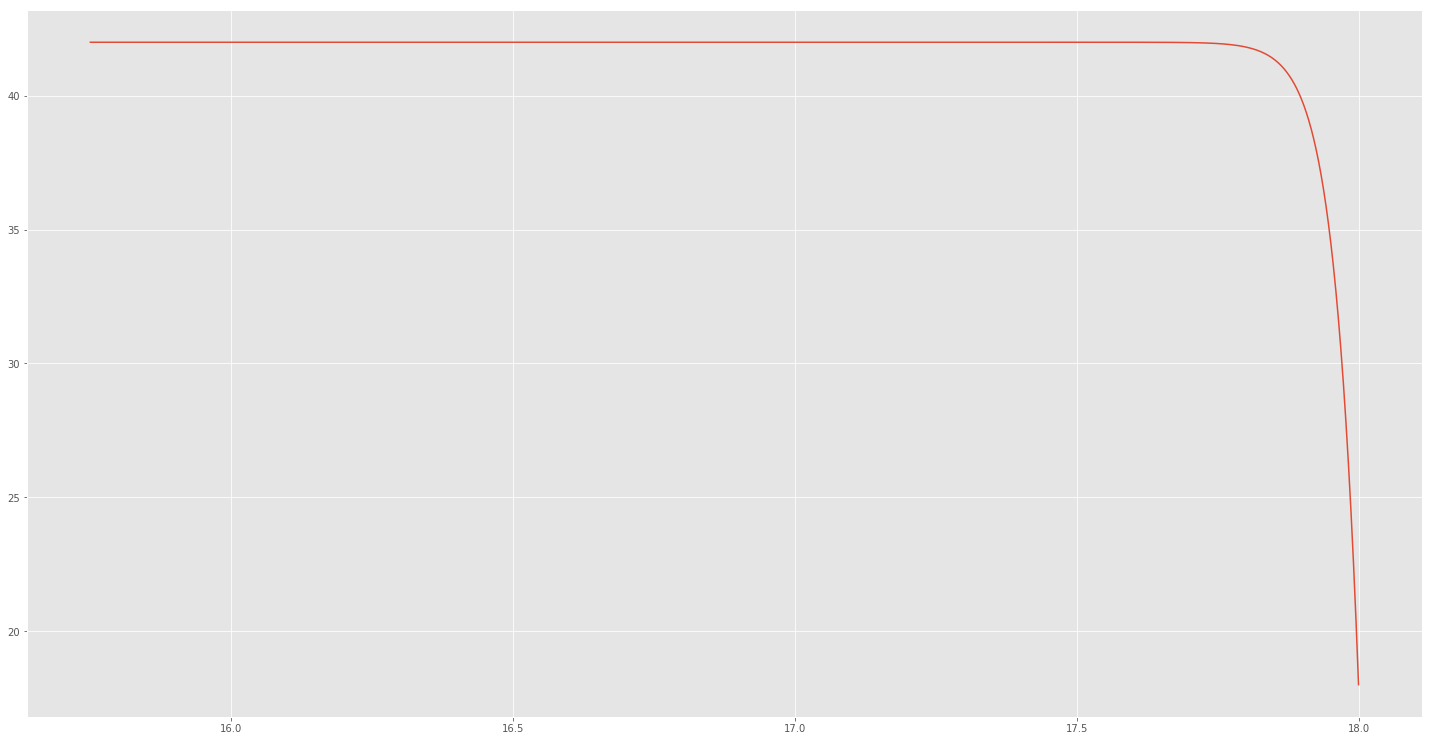

In [12]:
### Heaviside step function Classification 
N = 10000 #Number of iterations 
n = 30   #Number of neurons 
dt = 0.001 
T = zeros(N)

for i in range(N):
    T[i]=i*dt
    
tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #15 Constant (according to experiments)
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 2 #1.2
delC=0.015 #0.015
r=70 #70


#Define an array of parameters 
params = zeros(13)
params[0]=N #Iterations
params[1]=n #Neurons
params[2]=dt #Time Step
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r #Firing Rate
params[10]=V0 #Starting Voltage
params[11]=C0 #Starting Calcium Concentration  


#trials is how many times we are going to increment the parameter by a certain amount
trials1 = 18 #delV's
trials2 = 100 #n's
results = zeros((trials2,trials1))

#Save results of various runs into an array

'''
for i in range (trials2):
    for j in range (trials1):
        C,V = simdyn2(params)
        results[trials2-1-i,j] = classify(V,params)
        params[7] += .25
    params[7] = 0
    params[1] += 1
    
    #C,V = simdyn(params)
            # 1 = cycle, 2 = low V, 3 = high V
    #results[i] = classify(V,params)
            #pick a parameter and increment it
    #params[7] += .1
'''
#for i in range (trials2):
#    print(results[i])

'''
for i in range (trials2):
    for j in range (trials1): 
        scatter(results[i], transpose(results)[j])
show()
'''


C,V = simdyn2(params)
res = classify(V,params) 
print(res)
plot(C,V)
show()


In [ ]:
### Random connectivity 
#try doing the same classification probem using this matrix. 
#expect to see steps here. 

#Here we construct a random connectivity matrix
def getRandomConnectivity(N, pct_connected):
    # There is no self coupling so the diagonal must be zero. 
    # The graph is non directed so M must be symmetric
    M = np.random.rand(N**2).reshape(N,N)
    for i in range(N):
        for j in range(N):
            if (i == j):
                M[i,j] = 0
            else:
                if (M[i,j] < pct_connected):
                    M[i,j] = 1
                else:
                    M[i,j] = 0
    return M


In [8]:
# Recursive plotting of phase diagram. 
# Uses Heaviside Step function 
N = 10000 #Number of iterations 
n = 100   #Number of neurons 
dt = 0.001 
T = zeros(N)

for i in range(N):
    T[i]=i*dt
    
tauv=0.01 #0.01
tauc=0.5 #0.5
Vstar=15 #15 Constant (according to experiments)
Cstar=20 #20
V0=18 #18
C0=18 #18

delV= 1.2 #1.2
delC=0.015 #0.015
r=70 #70


#Define an array of parameters 
params = zeros(13)
params[0]=N #Iterations
params[1]=n #Neurons
params[2]=dt #Time Step
params[3]=tauv
params[4]=tauc
params[5]=Vstar
params[6]=Cstar
params[7]=delV
params[8]=delC
params[9]=r #Firing Rate
params[10]=V0 #Starting Voltage
params[11]=C0 #Starting Calcium Concentration 

#trials is how many times we are going to increment the parameter by a certain amount
trials1 = 18 #delV's
trials2 = 100 #n's
#results = zeros((trials2,trials1))

phasen = []
phaseV = []


dV = 0.1
delVmax = delV+5.0
while True:
    #import pdb; pdb.set_trace()
    C,V = simdyn2(params)
    check = classify(V,params)
    while True:
        #import pdb; pdb.set_trace()
        params[1] -= 1
        if params[1] <= 1:
            params[7] += dV
            params[1] = n
            break
        C,V = simdyn2(params)
        check2 = classify(V,params)
        if check2 > check:
            phasen.append(params[1])
            phaseV.append(params[7])
            params[7] += dV
            params[1] = n
            break
    import pdb; pdb.set_trace()
    if params[7] > delVmax:
        break
        

if len(phasen) > 0 and len(phaseV) > 0:
    plot(phasen[0],phaseV[0])
    show()
else:
    print('fail')
    

KeyboardInterrupt: 